In [1]:
import matplotlib.pyplot as plt
import torch
import os
from collections import Counter
from torchvision import transforms
from dataset import ChessDataset, INDEX_TO_PIECE, labels_to_fen, parse_full_fen

/Users/echen314/miniconda3/envs/chess_vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset without normalization so we can display raw images
TRAIN_DIR = "data/train"
MAX_SAMPLES = 500  # keep it fast for visualization

raw_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = ChessDataset(TRAIN_DIR, max_samples=MAX_SAMPLES, transform=raw_transform)
print(f"Dataset size: {len(dataset)}")
print(f"Manifest mode: {dataset.use_manifest}")
if dataset.use_manifest:
    sample = dataset.samples[0]
    print(f"Sample keys: {list(sample.keys())}")
    print(f"First sample: {sample}")

Dataset size: 500
Manifest mode: True
Sample keys: ['filename', 'fen', 'legal', 'turn', 'castling', 'en_passant', 'piece_count', 'has_highlight', 'style', 'flipped']
First sample: {'filename': '000000.png', 'fen': 'R2K1B1R/PPPB3P/2NP1N2/1b2P3/4p3/2n4p/ppppn3/r1bk3r b KQkq -', 'legal': '1', 'turn': 'b', 'castling': 'KQkq', 'en_passant': '-', 'piece_count': '26', 'has_highlight': '1', 'style': 'game_room_gothic', 'flipped': '1'}


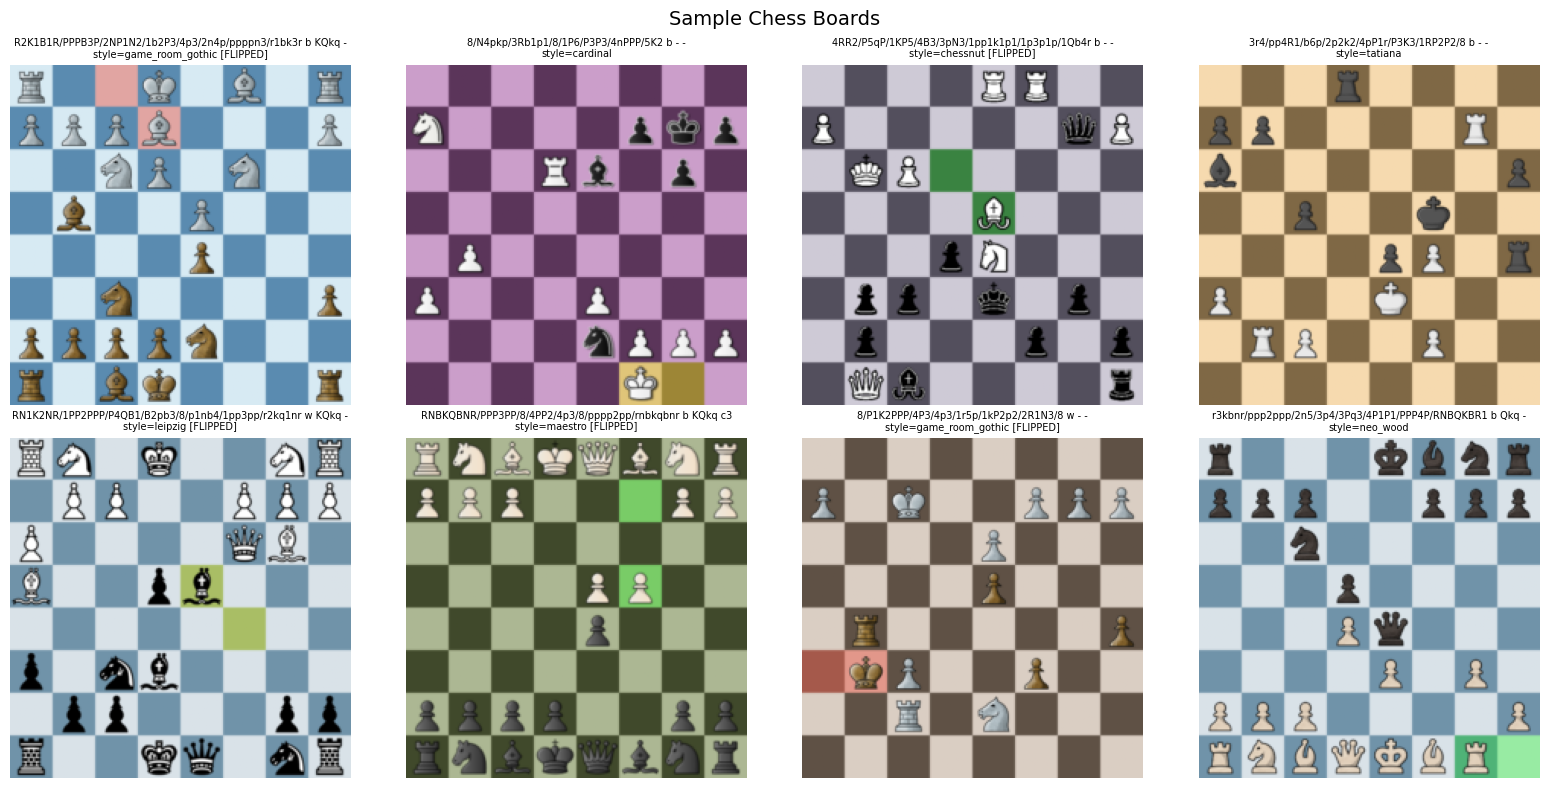

In [3]:
# Show a grid of sample boards with FEN, turn, and castling
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    image, labels = dataset[i]
    meta = dataset.get_metadata(i)
    fen = meta.get("fen", "?")
    style = meta.get("style", "?")
    flipped = meta.get("flipped", "0") == "1"

    ax.imshow(image.permute(1, 2, 0))
    title = f"{fen}\nstyle={style}"
    if flipped:
        title += " [FLIPPED]"
    ax.set_title(title, fontsize=7)
    ax.axis("off")
plt.suptitle("Sample Chess Boards", fontsize=14)
plt.tight_layout()
plt.show()

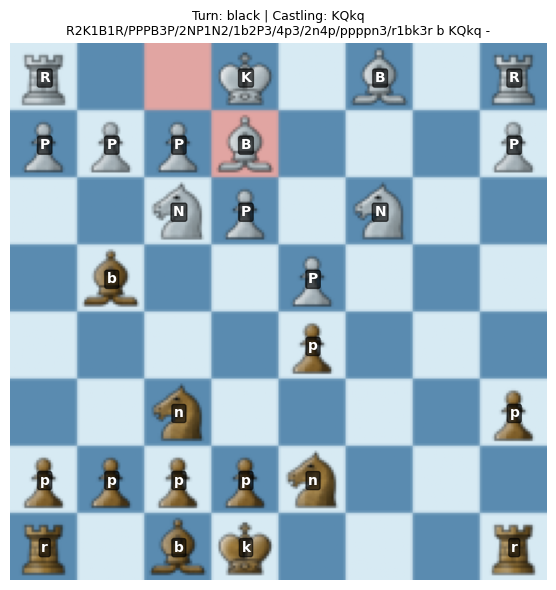

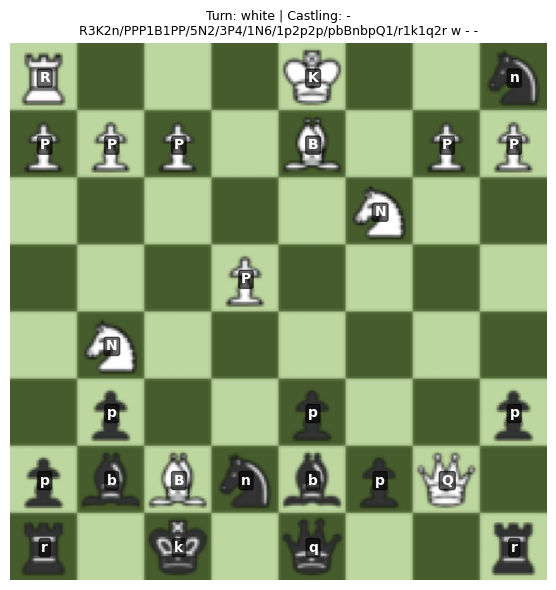

In [4]:
# Visualize one board with piece labels overlaid on each square
def show_board_with_labels(dataset, idx):
    image, labels = dataset[idx]
    meta = dataset.get_metadata(idx)
    fen = meta.get("fen", "?")

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image.permute(1, 2, 0))

    sq_size = 224 / 8
    for sq in range(64):
        row, col = divmod(sq, 8)
        piece = INDEX_TO_PIECE[labels["squares"][sq].item()]
        if piece != '.':
            ax.text(
                col * sq_size + sq_size / 2,
                row * sq_size + sq_size / 2,
                piece,
                ha="center", va="center",
                fontsize=10, fontweight="bold",
                color="white",
                bbox=dict(boxstyle="round,pad=0.15", fc="black", alpha=0.6),
            )

    turn = "white" if labels["turn"].item() < 0.5 else "black"
    castling = []
    for flag, ch in zip(labels["castling"].tolist(), ["K", "Q", "k", "q"]):
        if flag > 0.5:
            castling.append(ch)
    castling_str = "".join(castling) or "-"

    ax.set_title(f"Turn: {turn} | Castling: {castling_str}\n{fen}", fontsize=9)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

show_board_with_labels(dataset, 0)
show_board_with_labels(dataset, 42)

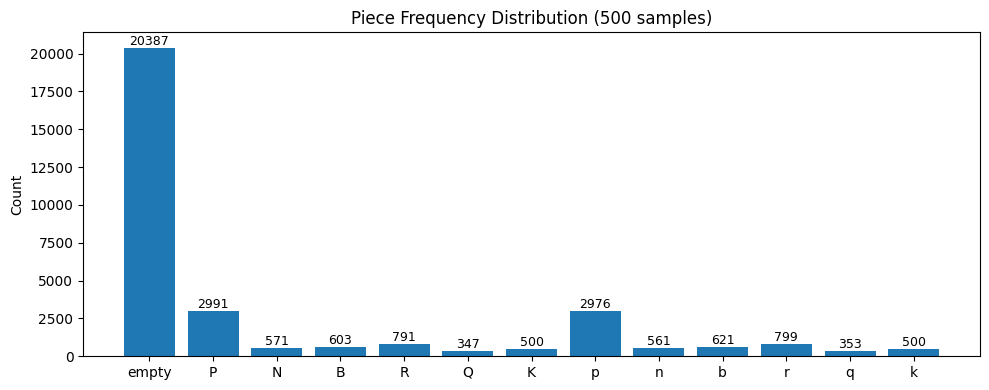

In [5]:
# Piece frequency distribution across the dataset
all_sq_labels = torch.stack([dataset[i][1]["squares"] for i in range(len(dataset))])  # (N, 64)
counts = torch.bincount(all_sq_labels.flatten(), minlength=13)

piece_names = [INDEX_TO_PIECE[i] for i in range(13)]
piece_names[0] = "empty"

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(piece_names, counts.numpy())
ax.set_ylabel("Count")
ax.set_title(f"Piece Frequency Distribution ({len(dataset)} samples)")
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            str(count.item()), ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

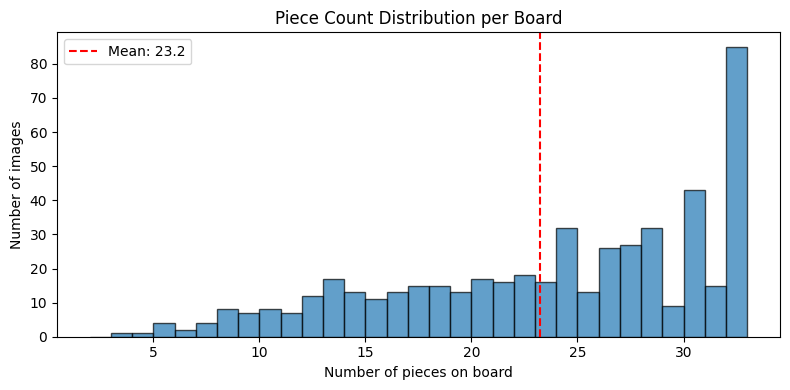

In [6]:
# Piece count per board — distribution across game phases
if dataset.use_manifest:
    piece_counts = [int(s.get("piece_count", 0)) for s in dataset.samples]
else:
    piece_counts = [(all_sq_labels[i] != 0).sum().item() for i in range(len(dataset))]

import numpy as np
piece_counts = np.array(piece_counts)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(piece_counts, bins=range(2, 34), edgecolor="black", alpha=0.7)
ax.set_xlabel("Number of pieces on board")
ax.set_ylabel("Number of images")
ax.set_title("Piece Count Distribution per Board")
ax.axvline(piece_counts.mean(), color="red", linestyle="--",
           label=f"Mean: {piece_counts.mean():.1f}")
ax.legend()
plt.tight_layout()
plt.show()

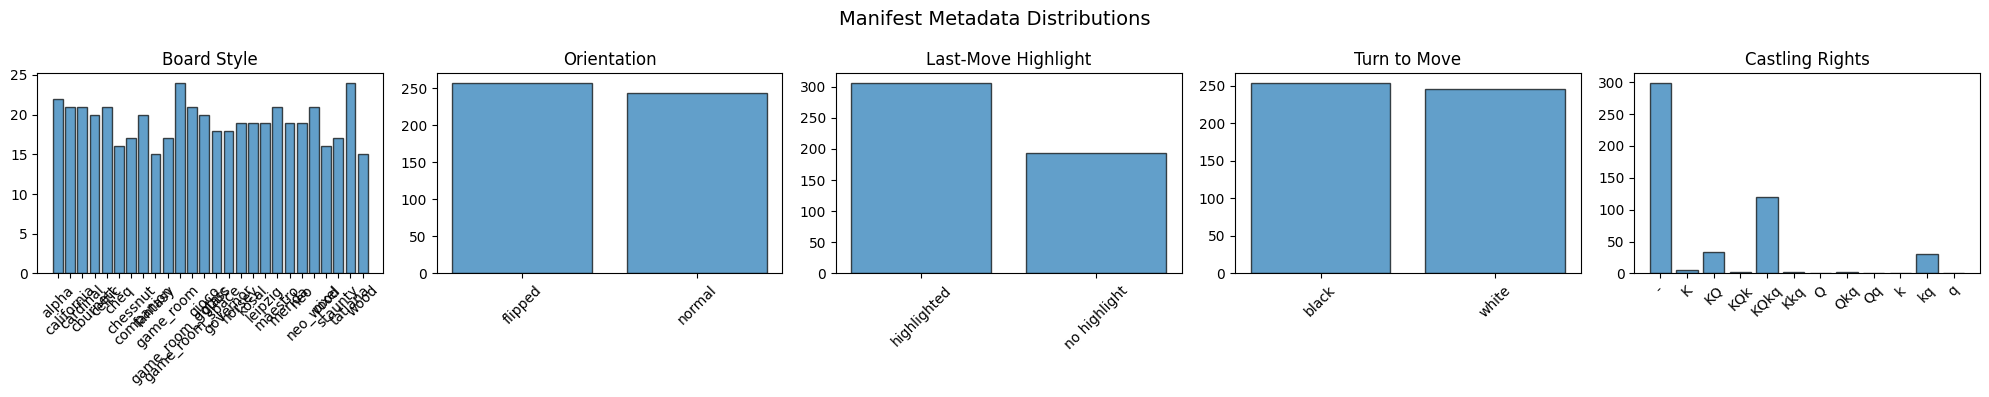

In [7]:
# Manifest metadata distributions (style, flipped, highlight, turn, castling)
if dataset.use_manifest:
    fields = {
        "style": "Board Style",
        "flipped": "Orientation",
        "has_highlight": "Last-Move Highlight",
        "turn": "Turn to Move",
        "castling": "Castling Rights",
    }
    label_maps = {
        "flipped": {"0": "normal", "1": "flipped"},
        "has_highlight": {"0": "no highlight", "1": "highlighted"},
        "turn": {"w": "white", "b": "black"},
    }

    fig, axes = plt.subplots(1, len(fields), figsize=(20, 4))
    for ax, (field, title) in zip(axes, fields.items()):
        values = [s.get(field, "?") for s in dataset.samples]
        lmap = label_maps.get(field, {})
        values = [lmap.get(v, v) for v in values]
        counts = Counter(values)
        keys = sorted(counts.keys())
        ax.bar(keys, [counts[k] for k in keys], edgecolor="black", alpha=0.7)
        ax.set_title(title)
        ax.tick_params(axis="x", rotation=45)
    plt.suptitle("Manifest Metadata Distributions", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No manifest — metadata distributions not available.")

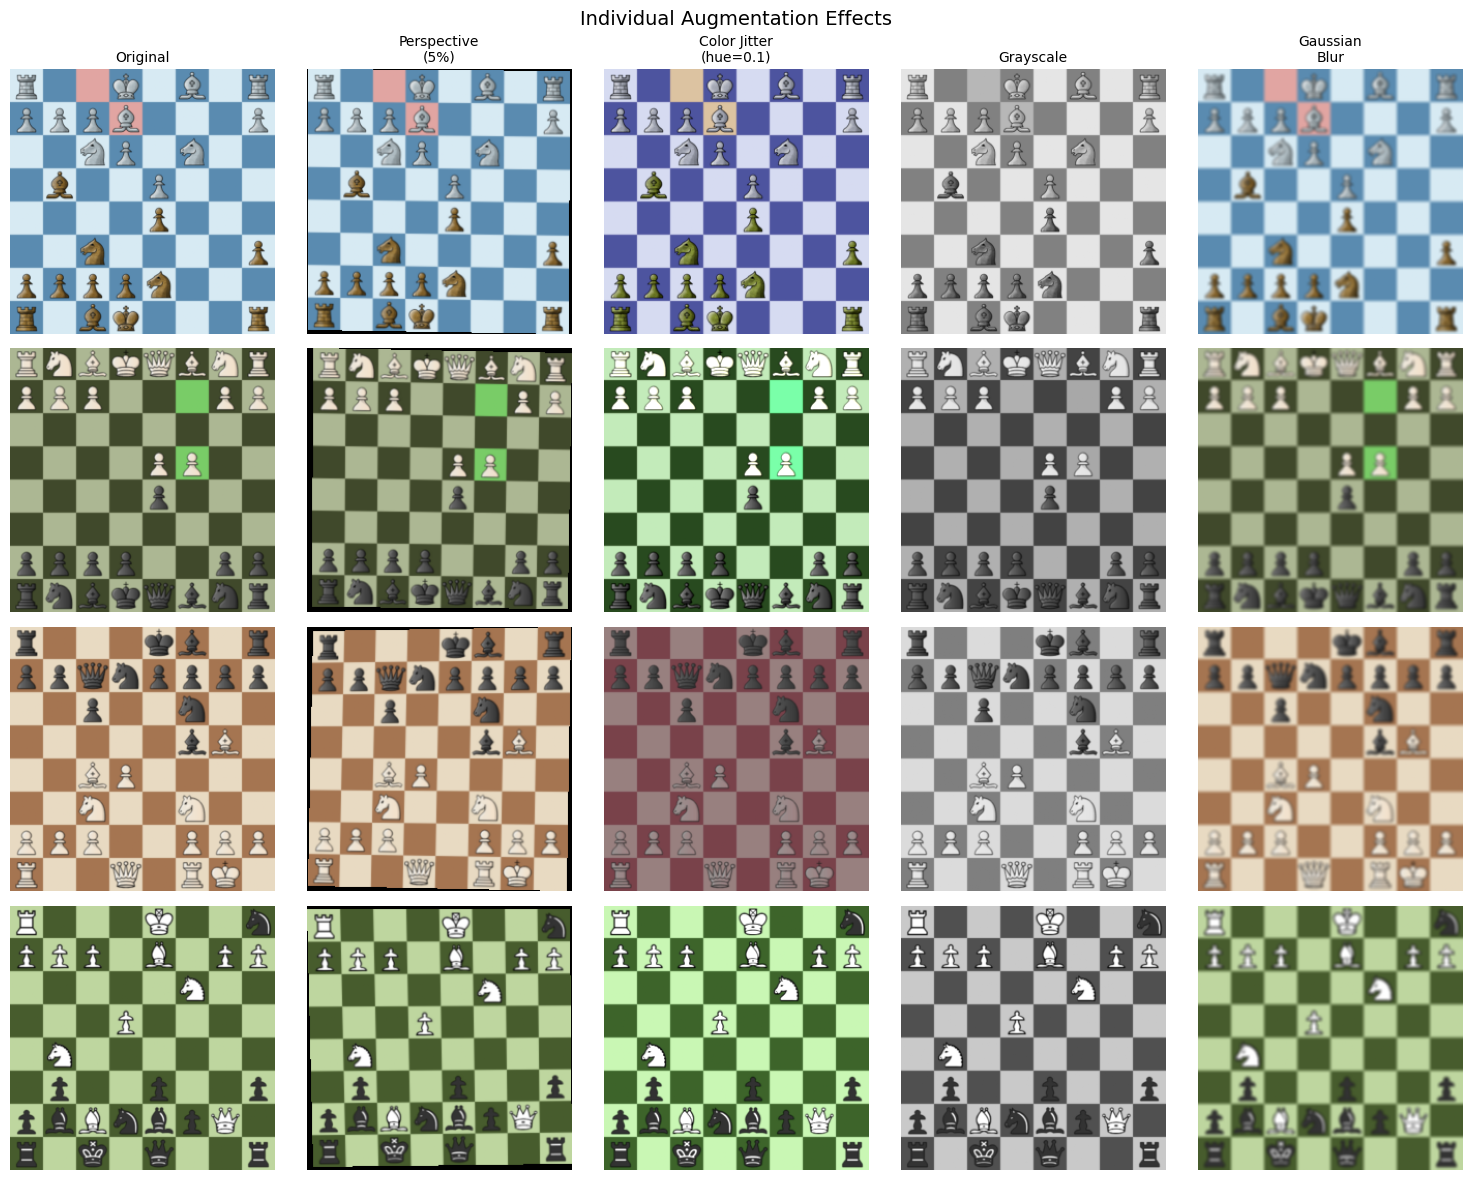

In [8]:
# Visualize each training augmentation individually
from dataset import get_transform, RandomChannelPermutation, RandomInvert
from PIL import Image
import numpy as np

def unnormalize(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Undo ImageNet normalization for display."""
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img.clamp(0, 1)

resize = transforms.Resize((256, 256))
to_tensor = transforms.ToTensor()

# Individual augmentations to visualize (matches training pipeline)
augmentations = {
    "Original": transforms.Compose([resize, to_tensor]),
    "Perspective\n(5%)": transforms.Compose([
        resize,
        transforms.RandomPerspective(distortion_scale=0.05, p=1.0),
        to_tensor,
    ]),
    "Color Jitter\n(hue=0.1)": transforms.Compose([
        resize,
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        to_tensor,
    ]),
    "Grayscale": transforms.Compose([
        resize,
        transforms.Grayscale(num_output_channels=3),
        to_tensor,
    ]),
    "Gaussian\nBlur": transforms.Compose([
        resize,
        transforms.GaussianBlur(kernel_size=5, sigma=1.5),
        to_tensor,
    ]),
}

sample_indices = [0, 5, 20, 42]
aug_names = list(augmentations.keys())
fig, axes = plt.subplots(len(sample_indices), len(aug_names), figsize=(3 * len(aug_names), 3 * len(sample_indices)))

for row, idx in enumerate(sample_indices):
    filename = dataset.samples[idx]["filename"]
    img_path = os.path.join(TRAIN_DIR, filename)
    pil_img = Image.open(img_path).convert("RGB")

    for col, (name, aug_t) in enumerate(augmentations.items()):
        img = aug_t(pil_img)
        axes[row, col].imshow(img.permute(1, 2, 0).numpy().clip(0, 1))
        if row == 0:
            axes[row, col].set_title(name, fontsize=10)
        axes[row, col].axis("off")

    axes[row, 0].set_ylabel(f"#{idx}", fontsize=10, rotation=0, labelpad=30)

plt.suptitle("Individual Augmentation Effects", fontsize=14)
plt.tight_layout()
plt.show()

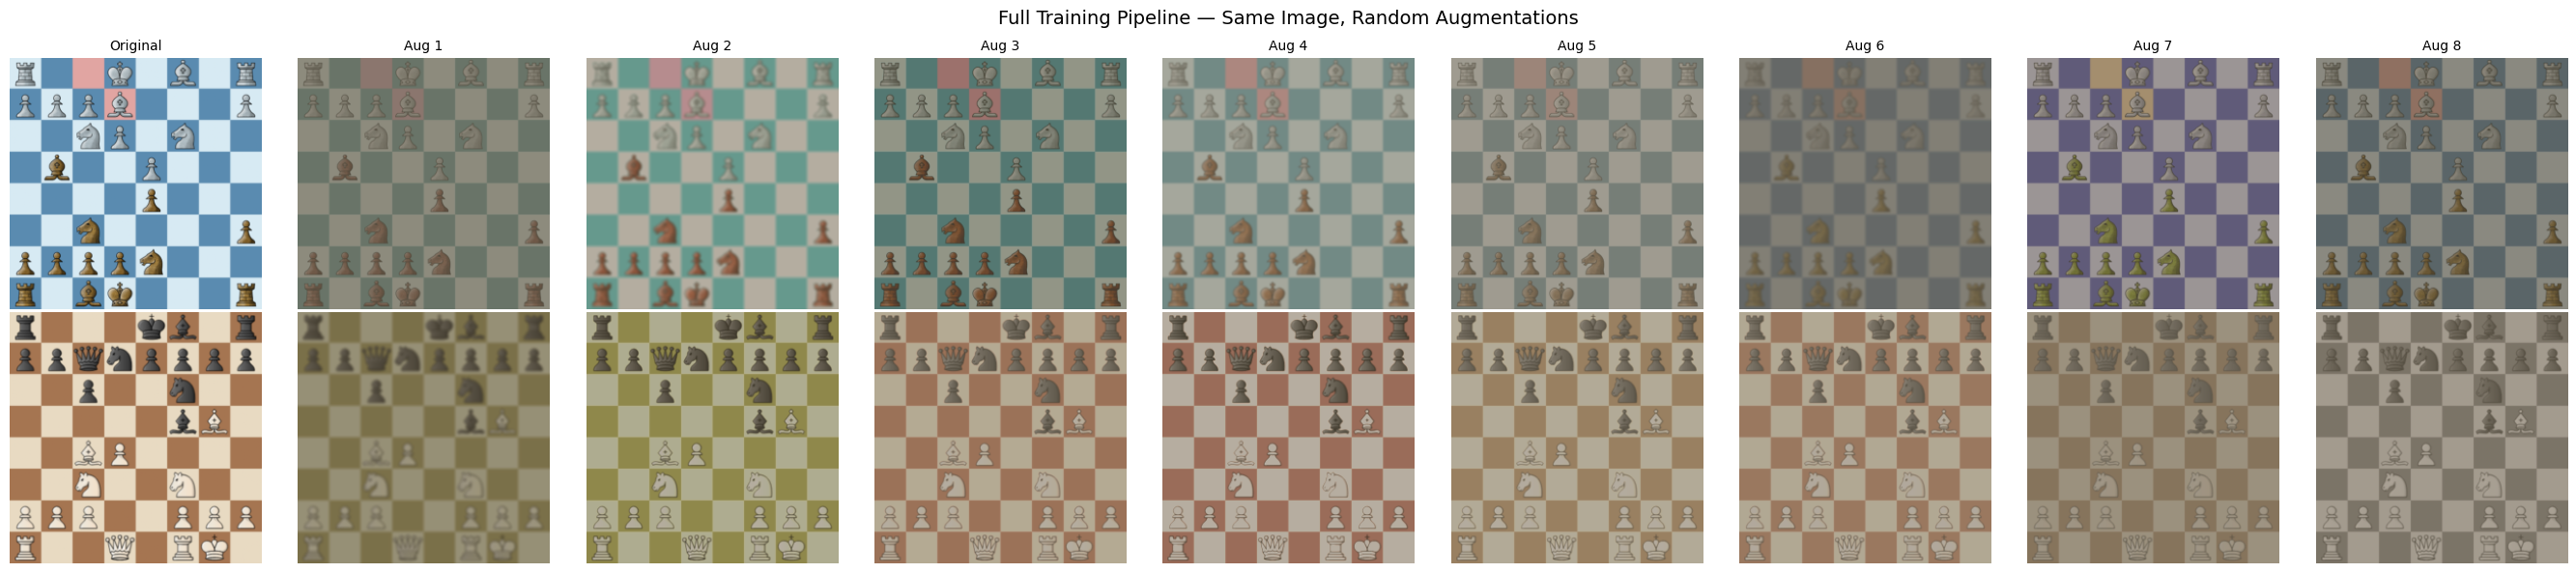

In [9]:
# Show variability of the full training pipeline — same image, 8 random augmentations
train_t = get_transform("vit_base_patch16_224.augreg_in21k", is_training=True, input_size=256)

sample_indices = [0, 20]
n_augments = 8

fig, axes = plt.subplots(len(sample_indices), n_augments + 1, figsize=(3 * (n_augments + 1), 3 * len(sample_indices)))

for row, idx in enumerate(sample_indices):
    filename = dataset.samples[idx]["filename"]
    img_path = os.path.join(TRAIN_DIR, filename)
    pil_img = Image.open(img_path).convert("RGB")

    # Original
    raw_img = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])(pil_img)
    axes[row, 0].imshow(raw_img.permute(1, 2, 0).numpy())
    if row == 0:
        axes[row, 0].set_title("Original", fontsize=10)
    axes[row, 0].axis("off")
    axes[row, 0].set_ylabel(f"#{idx}", fontsize=10, rotation=0, labelpad=30)

    # Augmented samples
    for col in range(1, n_augments + 1):
        aug_img = unnormalize(train_t(pil_img))
        axes[row, col].imshow(aug_img.permute(1, 2, 0).numpy().clip(0, 1))
        if row == 0:
            axes[row, col].set_title(f"Aug {col}", fontsize=10)
        axes[row, col].axis("off")

plt.suptitle("Full Training Pipeline — Same Image, Random Augmentations", fontsize=14)
plt.tight_layout()
plt.show()

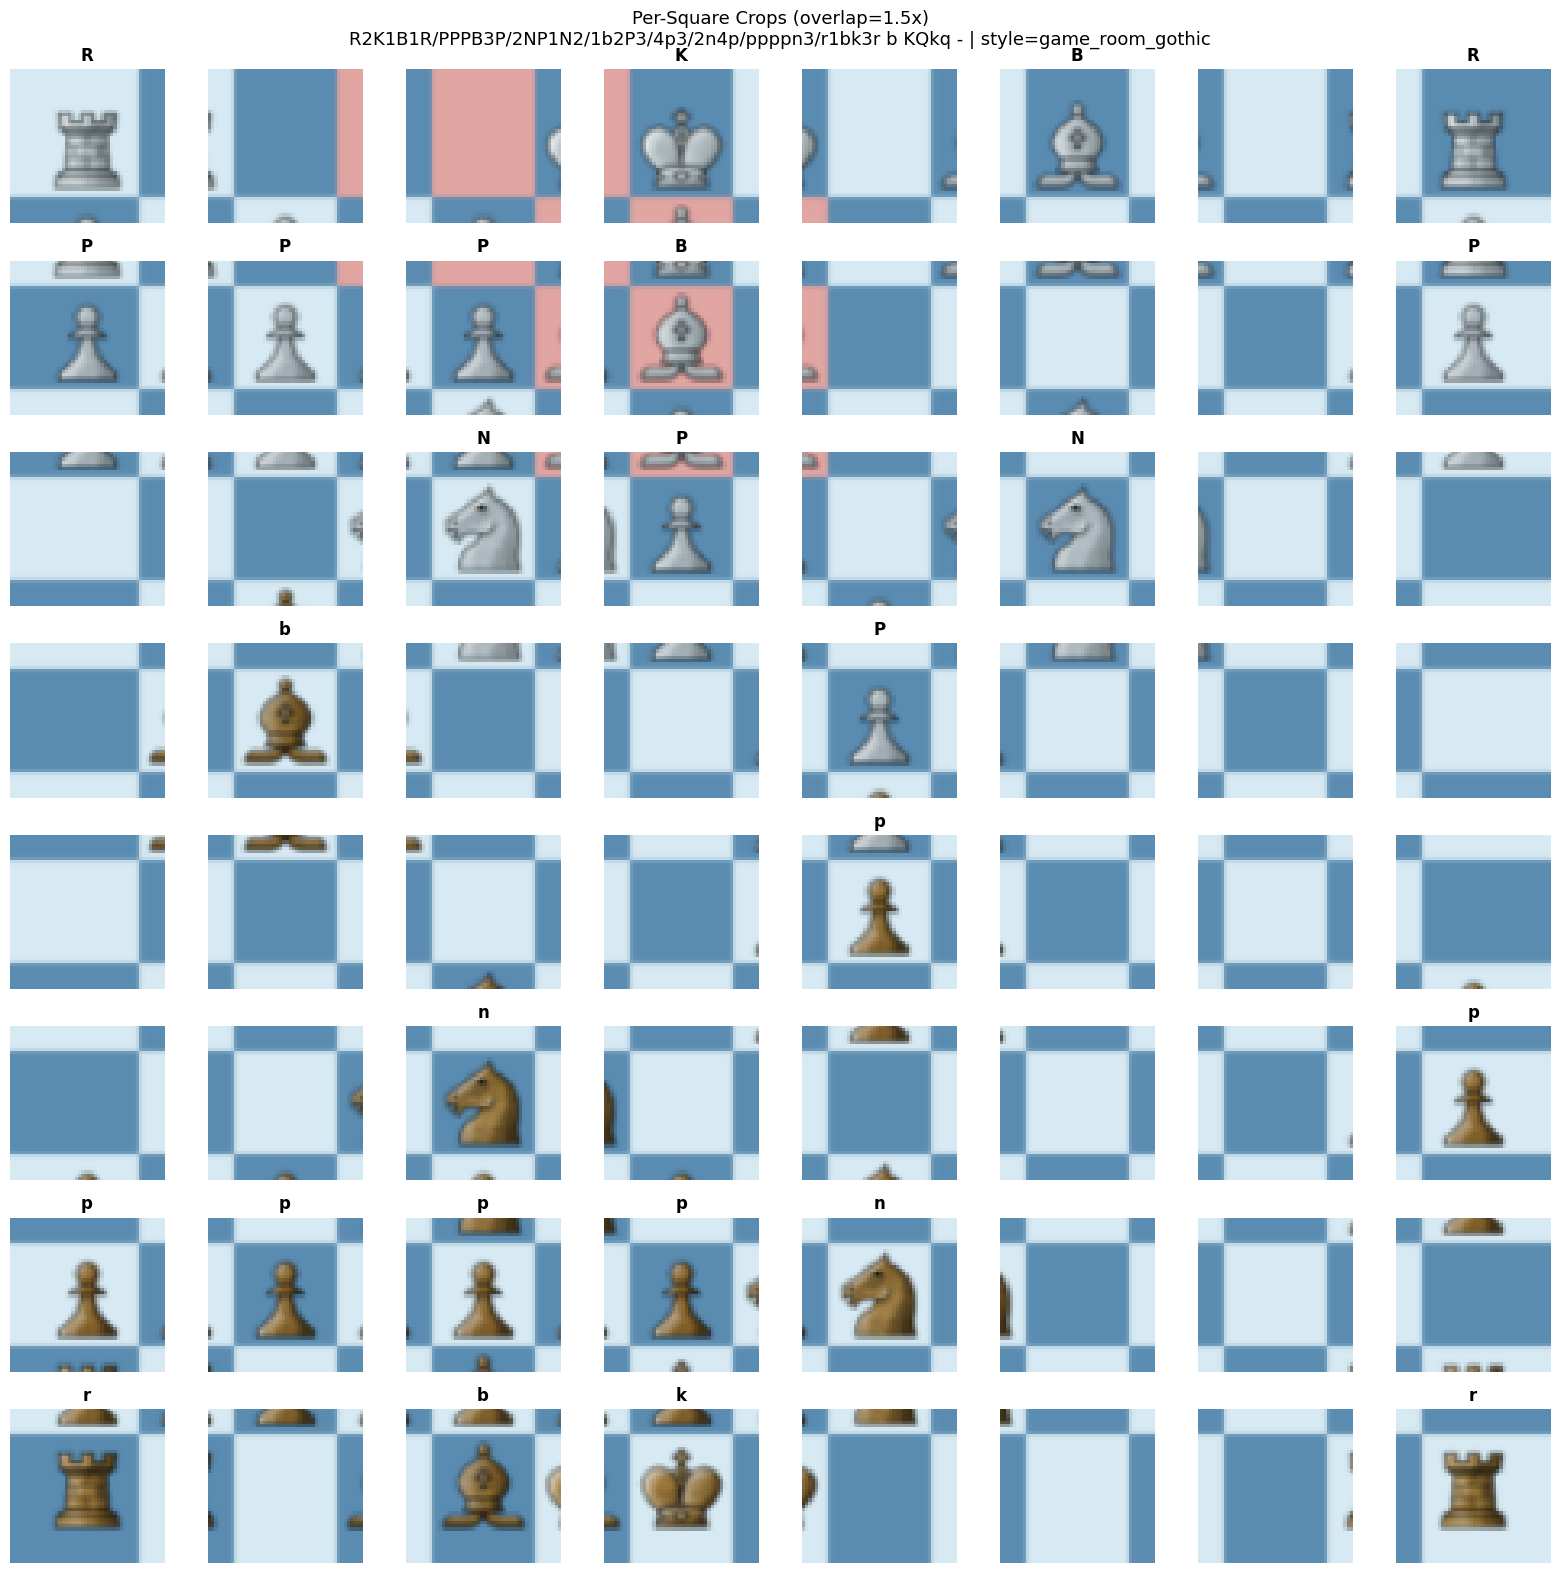

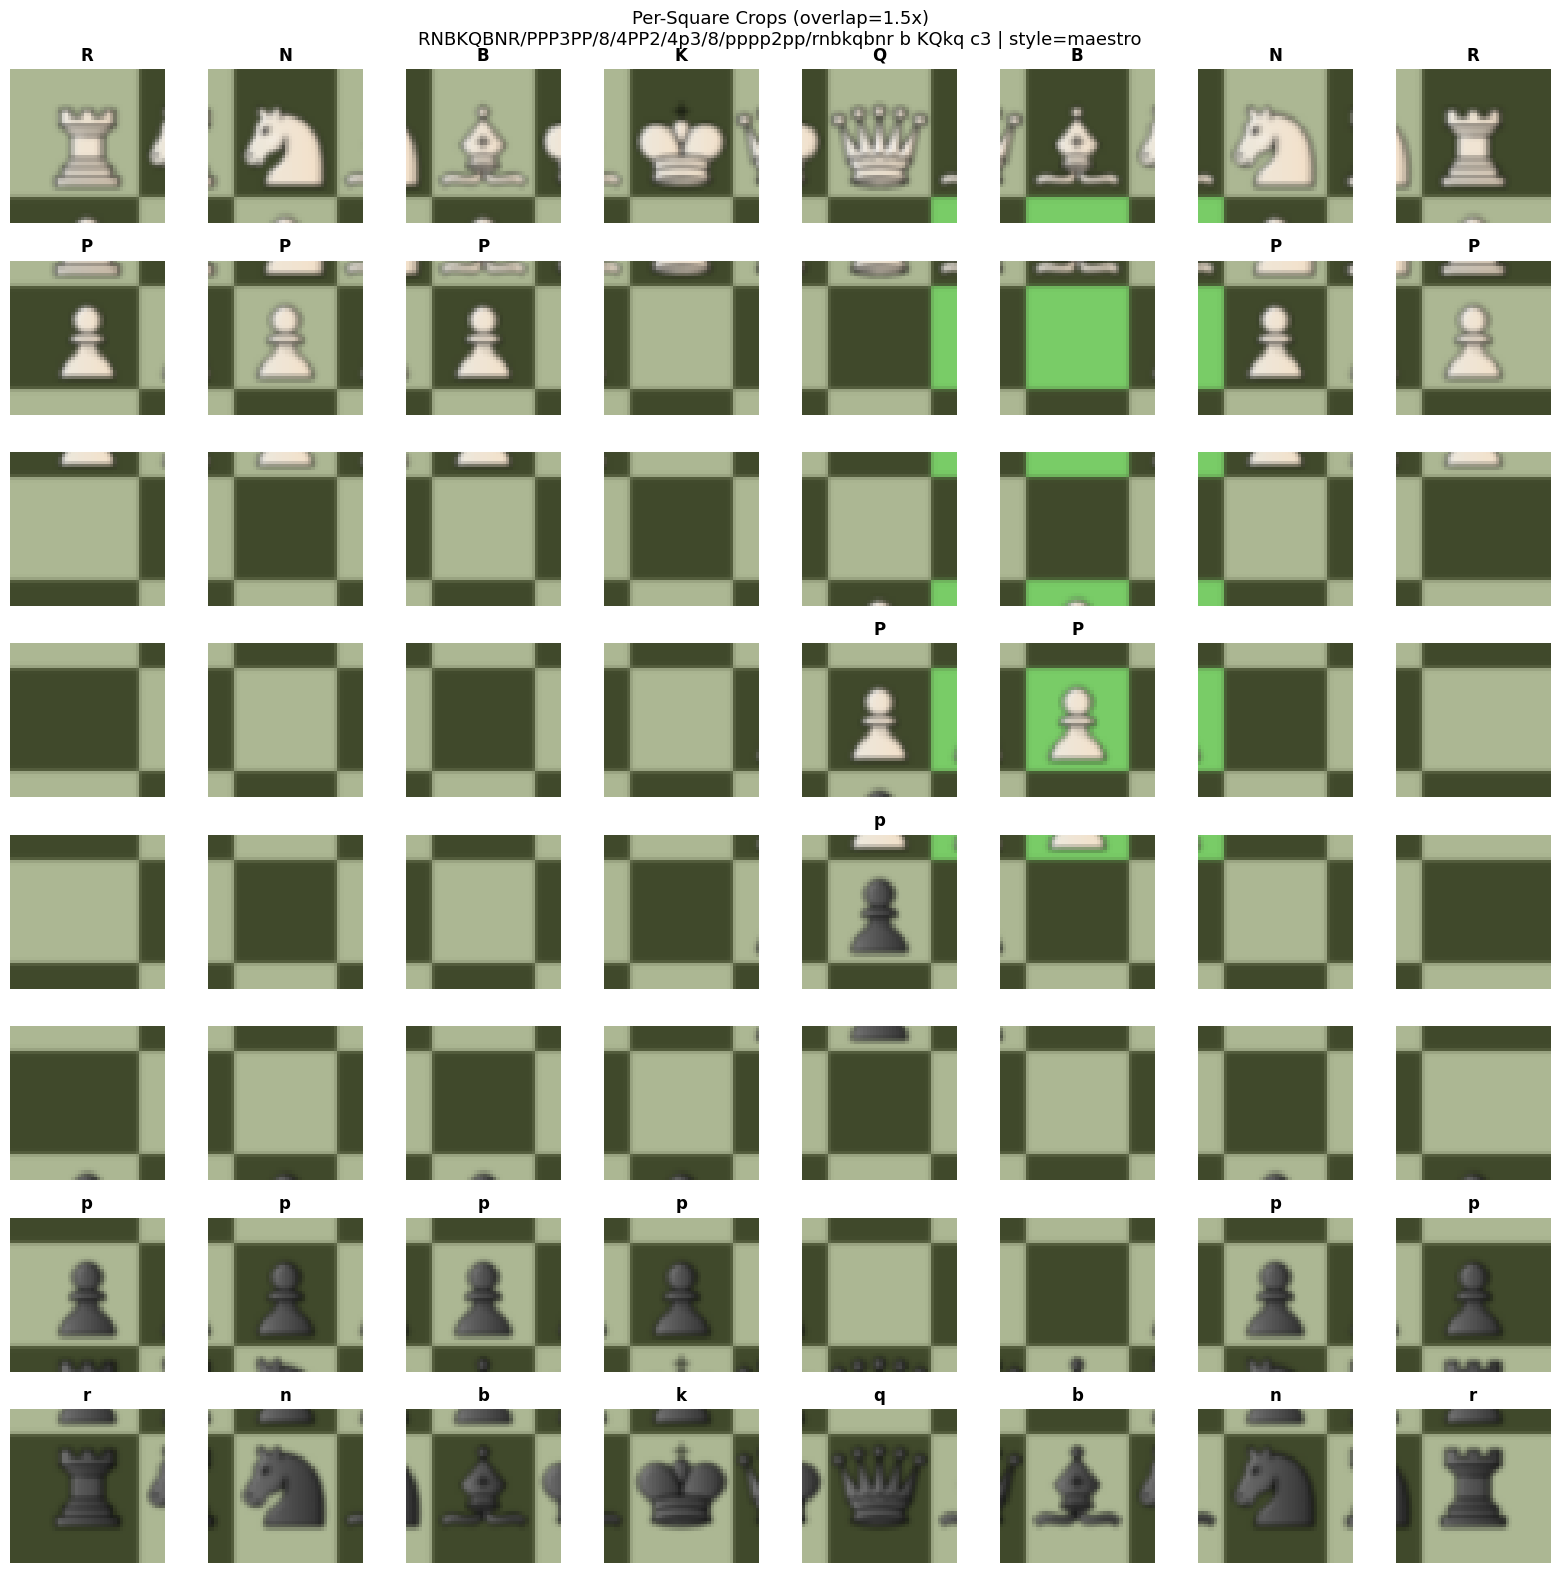

In [10]:
# Visualize what the per-square model sees: 64 cropped squares from a board image
from models.square import ChessSquareCNN
import torch.nn.functional as F

def visualize_square_crops(dataset, idx, overlap=1.5, input_size=256):
    """Show the 64 square crops the square model extracts from a board."""
    image, labels = dataset[idx]
    meta = dataset.get_metadata(idx)

    # Resize to model input size
    img = F.interpolate(image.unsqueeze(0), size=input_size, mode="bilinear", align_corners=False)[0]
    
    H = input_size
    sq_size = H // 8  # 32
    crop_size = int(sq_size * overlap)  # 48
    pad = (crop_size - sq_size) // 2  # 8
    
    padded = F.pad(img.unsqueeze(0), [pad, pad, pad, pad], mode="replicate")[0]
    
    fig, axes = plt.subplots(8, 8, figsize=(16, 16))
    
    for row in range(8):
        for col in range(8):
            y = row * sq_size
            x = col * sq_size
            crop = padded[:, y:y + crop_size, x:x + crop_size]
            
            sq_idx = row * 8 + col
            piece = INDEX_TO_PIECE[labels["squares"][sq_idx].item()]
            
            axes[row, col].imshow(crop.permute(1, 2, 0).numpy().clip(0, 1))
            axes[row, col].set_title(piece if piece != '.' else '', fontsize=12, fontweight='bold')
            axes[row, col].axis("off")
            
            # Red border for pieces, gray for empty
            color = 'red' if piece != '.' else '#cccccc'
            for spine in axes[row, col].spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(2)
                spine.set_visible(True)
    
    fen = meta.get("fen", "?")
    style = meta.get("style", "?")
    plt.suptitle(f"Per-Square Crops (overlap={overlap}x)\n{fen} | style={style}", fontsize=13)
    plt.tight_layout()
    plt.show()

# Show crops for a few different boards
visualize_square_crops(dataset, 0)
visualize_square_crops(dataset, 5)

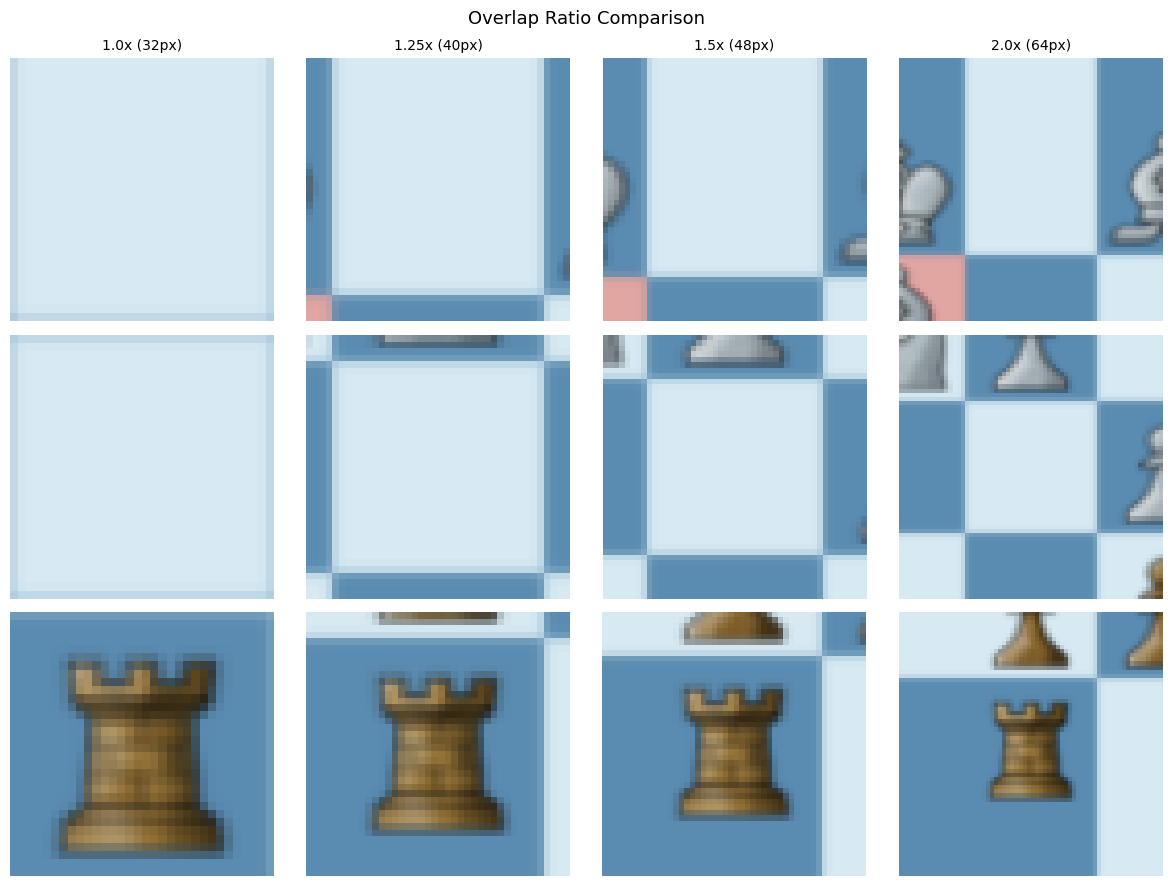

In [11]:
# Compare different overlap ratios for a few squares
def compare_overlaps(dataset, idx, squares_to_show=[(0,4), (3,3), (7,0)], input_size=256):
    """Show how overlap ratio affects the crop for specific squares."""
    image, labels = dataset[idx]
    img = F.interpolate(image.unsqueeze(0), size=input_size, mode="bilinear", align_corners=False)[0]
    
    overlaps = [1.0, 1.25, 1.5, 2.0]
    fig, axes = plt.subplots(len(squares_to_show), len(overlaps), figsize=(3 * len(overlaps), 3 * len(squares_to_show)))
    
    for row_i, (sq_row, sq_col) in enumerate(squares_to_show):
        sq_idx = sq_row * 8 + sq_col
        piece = INDEX_TO_PIECE[labels["squares"][sq_idx].item()]
        
        for col_i, overlap in enumerate(overlaps):
            sq_size = input_size // 8
            crop_size = int(sq_size * overlap)
            pad = (crop_size - sq_size) // 2
            padded = F.pad(img.unsqueeze(0), [pad, pad, pad, pad], mode="replicate")[0]
            
            y = sq_row * sq_size
            x = sq_col * sq_size
            crop = padded[:, y:y + crop_size, x:x + crop_size]
            
            axes[row_i, col_i].imshow(crop.permute(1, 2, 0).numpy().clip(0, 1))
            if row_i == 0:
                axes[row_i, col_i].set_title(f"{overlap}x ({crop_size}px)", fontsize=10)
            axes[row_i, col_i].axis("off")
        
        label = piece if piece != '.' else 'empty'
        axes[row_i, 0].set_ylabel(f"({sq_row},{sq_col}) {label}", fontsize=10, rotation=0, labelpad=60)
    
    plt.suptitle("Overlap Ratio Comparison", fontsize=13)
    plt.tight_layout()
    plt.show()

compare_overlaps(dataset, 0)

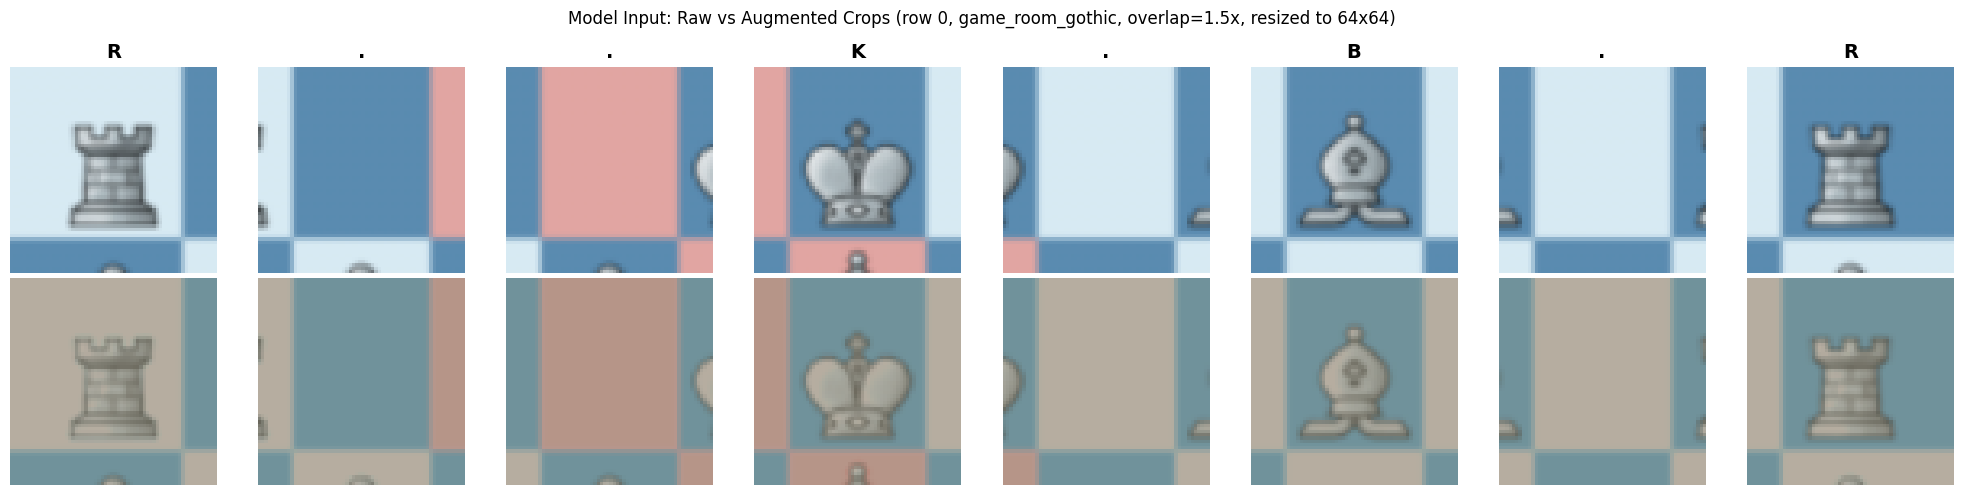

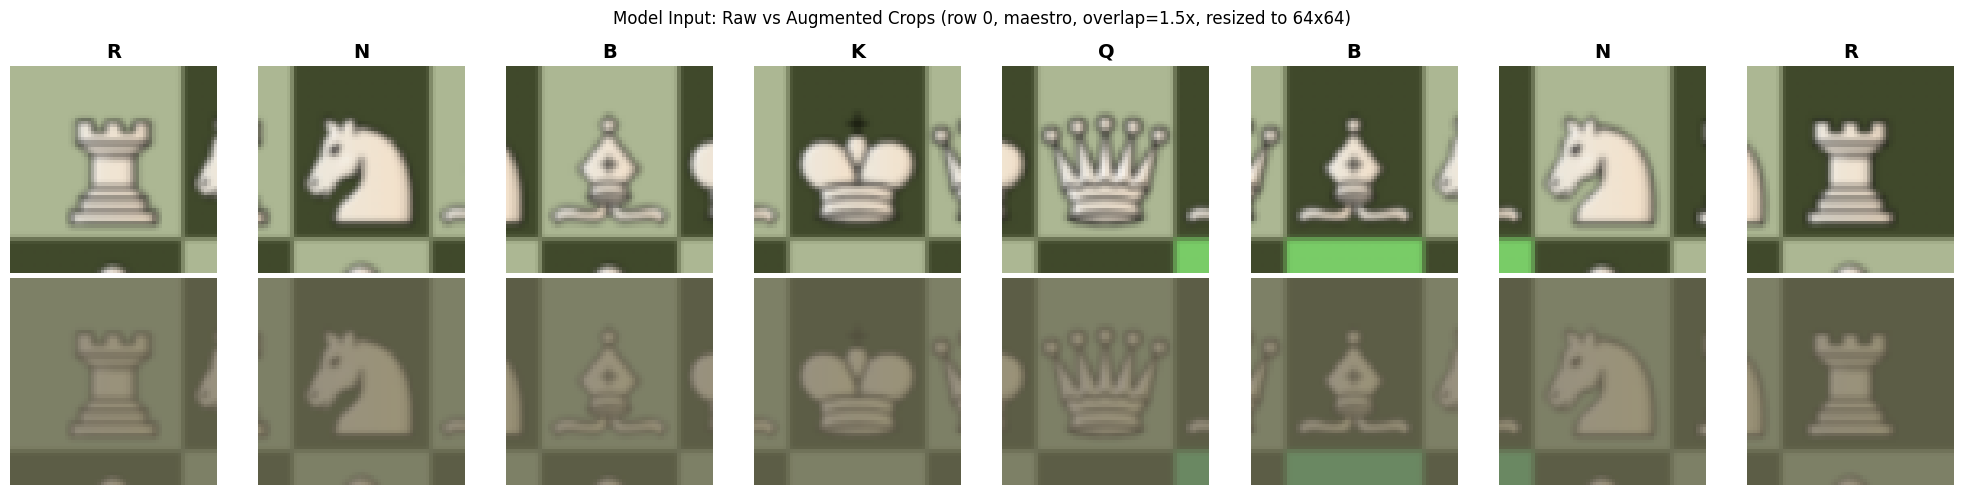

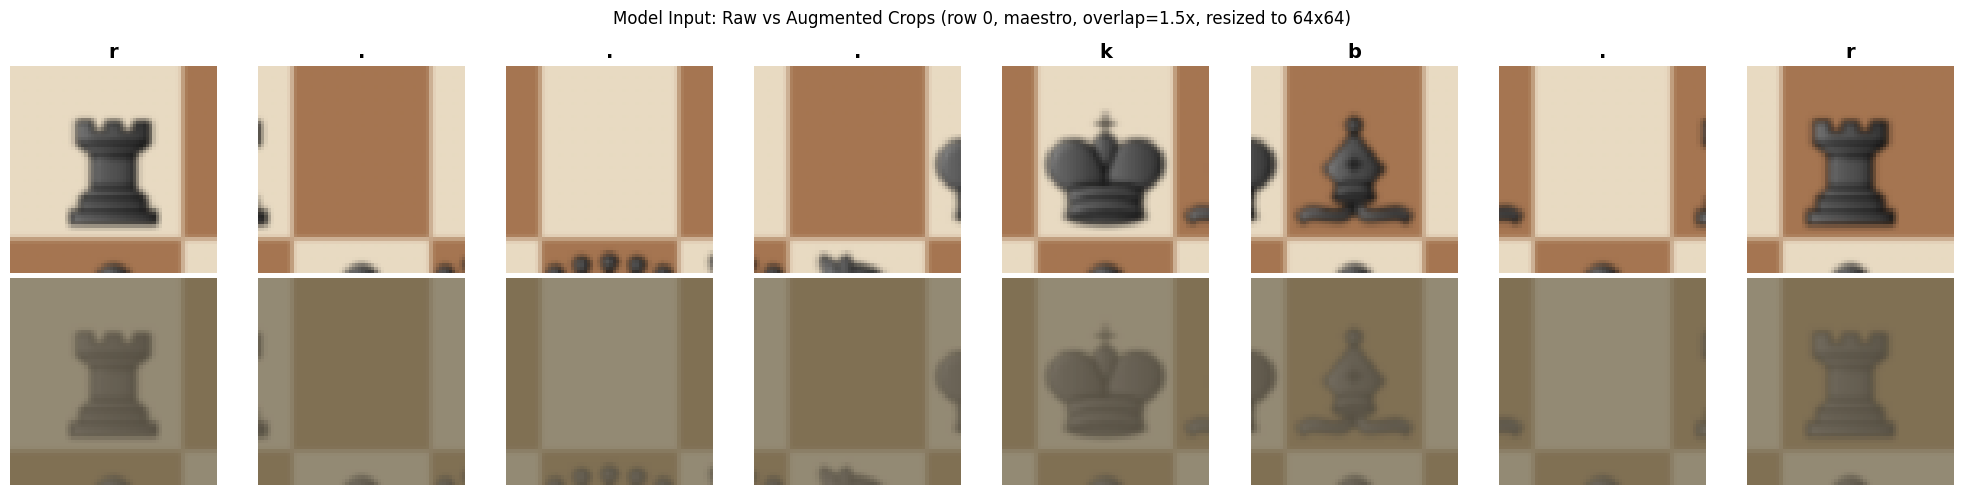

In [12]:
# What the square model ACTUALLY sees during training:
# Full augmentation pipeline → normalize → crop → resize
# Side by side: raw crops vs augmented+normalized crops (unnormalized for display)

from dataset import get_transform

def visualize_train_vs_clean_crops(idx, overlap=1.5, input_size=256):
    """Compare raw crops vs what the model sees after augmentation+normalization."""
    from PIL import Image
    filename = dataset.samples[idx]["filename"]
    img_path = os.path.join(TRAIN_DIR, filename)
    pil_img = Image.open(img_path).convert("RGB")
    _, labels = dataset[idx]
    meta = dataset.get_metadata(idx)

    # Raw: resize + ToTensor only
    raw_t = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor()])
    raw_img = raw_t(pil_img)

    # Augmented: full training pipeline (includes normalize)
    train_t = get_transform("mobilenetv4_conv_small_050.e3000_r224_in1k", is_training=True, input_size=input_size)
    aug_img = train_t(pil_img)
    # Unnormalize for display
    aug_display = unnormalize(aug_img)

    sq_size = input_size // 8
    crop_size = int(sq_size * overlap)
    pad = (crop_size - sq_size) // 2

    # Select a row of 8 squares to show (e.g., rank 8 = row 0, or a row with pieces)
    # Find a row with some pieces
    show_row = 0
    for r in range(8):
        count = sum(1 for c in range(8) if labels["squares"][r * 8 + c].item() != 0)
        if count >= 3:
            show_row = r
            break

    fig, axes = plt.subplots(2, 8, figsize=(20, 5))

    for col in range(8):
        sq_idx = show_row * 8 + col
        piece = INDEX_TO_PIECE[labels["squares"][sq_idx].item()]

        for row_i, (img_tensor, title_prefix) in enumerate([
            (raw_img, "Raw"),
            (aug_display, "Augmented"),
        ]):
            padded = F.pad(img_tensor.unsqueeze(0), [pad, pad, pad, pad], mode="replicate")[0]
            y = show_row * sq_size
            x = col * sq_size
            crop = padded[:, y:y + crop_size, x:x + crop_size]
            # Resize to what model sees
            crop_resized = F.interpolate(
                crop.unsqueeze(0), size=64, mode="bilinear", align_corners=False
            )[0]

            axes[row_i, col].imshow(crop_resized.permute(1, 2, 0).numpy().clip(0, 1))
            if col == 0:
                axes[row_i, col].set_ylabel(title_prefix, fontsize=11, rotation=0, labelpad=60)
            if row_i == 0:
                label = piece if piece != '.' else '.'
                axes[row_i, col].set_title(label, fontsize=14, fontweight='bold')
            axes[row_i, col].axis("off")

    style = meta.get("style", "?")
    plt.suptitle(f"Model Input: Raw vs Augmented Crops (row {show_row}, {style}, overlap={overlap}x, resized to 64x64)", fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_train_vs_clean_crops(0)
visualize_train_vs_clean_crops(5)
visualize_train_vs_clean_crops(20)